In [1]:
# https://arxiv.org/pdf/1808.06910.pdf

## Import Libraries and Datasets

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")

## Choose PUMS and Preprocess

In [4]:
# Filter to desired variables (numeric then categorical)
pums_data = p_df[['AGEP','JWMNP','SCHL','PINCP','COW','SEX','MAR']]

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

Dataset n=359075 pre-cleaning
Dataset n=152416 post-cleaning


In [5]:
CAT_IDX = 4
VAR_DIM = pums_data.shape[1]
VAR_NAMES = pums_data.columns

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
for x in range(CAT_IDX, VAR_DIM):
    dummies = pums_data.iloc[:,x]
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]

In [6]:
# Final data frame after encoding OHE
model_data_df = pums_data.iloc[:,:CAT_IDX]
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
MANIFEST_DIM = model_data_df.shape[1]

# Preview data that will be fed into model
model_data_df

,AGEP,JWMNP,SCHL,PINCP,COW__1.0,COW__2.0,COW__3.0,COW__4.0,COW__5.0,COW__6.0,COW__7.0,COW__8.0,SEX__1,SEX__2,MAR__1,MAR__2,MAR__3,MAR__4,MAR__5
4,52,70.0,21.0,160000.0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
5,51,20.0,21.0,50000.0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
7,59,30.0,19.0,26710.0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
8,56,15.0,16.0,23600.0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
9,40,5.0,5.0,10000.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359058,21,4.0,19.0,2700.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
359065,21,90.0,14.0,8200.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
359070,22,35.0,16.0,37200.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
359071,19,7.0,18.0,5300.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [7]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.9)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

# Standardize the input data from -1 to 1 for numerical variables
scaler_train = skpre.StandardScaler()
scaler_test = skpre.StandardScaler()

# Separate the scaling for train/test so that no overall mean/std info is carried
train_data[:,:CAT_IDX] = scaler_train.fit_transform(train_data[:,:CAT_IDX])
test_data[:,:CAT_IDX] = scaler_test.fit_transform(test_data[:,:CAT_IDX])

# Remove rows with numerical outliers (3 < standard deviations)
outlier_row_indices = np.where(np.any(train_data[:,:CAT_IDX] > 3, axis=1))
train_data = np.delete(train_data, (outlier_row_indices), axis=0)
outlier_row_indices = np.where(np.any(test_data[:,:CAT_IDX] > 3, axis=1))
test_data = np.delete(test_data, (outlier_row_indices), axis=0)

## Set Parameters and Define Model

In [8]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 100
LEARN_RATE = 0.001
RHO = 0.9
LATENT_DIM = 5
HIDDEN_DIM = 100
KL_WEIGHT = 0.5

In [9]:
# A layer that takes mean/variance as inputs and returns a random sample z
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

In [10]:
# Encoder
encoder_inputs = keras.Input(shape=(MANIFEST_DIM,))
encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_inputs)
encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(encoder_x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(encoder_x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 19)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          2000        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          10100       dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 5)            505         dense_1[0][0]                    
____________________________________________________________________________________________

In [11]:
# Decoder
decoder_inputs = keras.Input(shape=(LATENT_DIM,))
decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_inputs)
decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_x)
decoder_num_outputs = layers.Dense(CAT_IDX, activation="linear")(decoder_x)
decoder_cat_outputs = []
for var_length in CAT_LENGTHS:
    layer = layers.Dense(var_length, activation="softmax")(decoder_x)
    decoder_cat_outputs.append(layer)
decoder = keras.Model(decoder_inputs, [decoder_num_outputs, decoder_cat_outputs], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          600         input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          10100       dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 4)            404         dense_3[0][0]                    
____________________________________________________________________________________________

In [12]:
# Define custom loss function for combined numerical and categorical data
def get_reconstruction_loss(data, reconstruction, CAT_IDX, CAT_LENGTHS):

    # Mean squared error for numerical variables
    data_num = data[:,:CAT_IDX]
    reconstruction_num = reconstruction[0]
    loss_num = keras.losses.mean_squared_error(data_num, reconstruction_num)
    loss_num = tf.reduce_mean(loss_num)
    
    # Categorical cross entropy for categorical variables
    loss_list = []
    current = CAT_IDX
    for i, x in enumerate(CAT_LENGTHS):
        data_cat = data[:,current:(current + x)]
        reconstruction_cat = reconstruction[1][i]
        loss = keras.losses.categorical_crossentropy(data_cat, reconstruction_cat, from_logits=False)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss)
        current += x
    loss_cat = tf.reduce_sum(loss_list)

    # Return both losses; they are combined in the model
    return (loss_num, loss_cat)

def get_kl_loss(z_mean, z_log_var):
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss = -kl_loss
    return kl_loss

In [13]:
# Loss metric recorder
loss_tracker = keras.metrics.Mean(name="loss")

# Variational Autoencoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, CAT_IDX, CAT_LENGTHS, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.CAT_IDX = CAT_IDX
        self.CAT_LENGTHS = CAT_LENGTHS

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # Get latent vars from the encoder; feed to decoder and get sampled manifest variables
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)

            # Get loss between input values and reconstruction
            reconstruction_loss_num, reconstruction_loss_cat = get_reconstruction_loss(
                data,
                reconstruction,
                self.CAT_IDX,
                self.CAT_LENGTHS
            )
            reconstruction_loss = tf.add(reconstruction_loss_num, reconstruction_loss_cat)

            # Get Kullback Leidler loss between normal distribution and actual for latent variables
            kl_loss = get_kl_loss(z_mean, z_log_var)
            kl_loss = kl_loss * KL_WEIGHT

            # Combine into single loss term
            total_loss = reconstruction_loss + kl_loss

        # Get new gradients given the loss and take another step (update weights)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Record the loss metrics
        loss_tracker.update_state(total_loss)

        return {
            "total_loss": loss_tracker.result(),
            "reconstruction_loss": reconstruction_loss,
            "reconstruction_loss_num": reconstruction_loss_num,
            "reconstruction_loss_cat": reconstruction_loss_cat,
            "kl_loss": kl_loss,
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    @property
    def metrics(self):
        return [loss_tracker]

## Training

In [14]:
# Train
vae = VAE(encoder, decoder, CAT_IDX, CAT_LENGTHS)
vae.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARN_RATE, rho=RHO))
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE) #add callbacks=[callback] if needed

Epoch 1/100
2068/2068 [==============================] - 4s 2ms/step - total_loss: 1.5311 - reconstruction_loss: 0.6088 - reconstruction_loss_num: 0.3680 - reconstruction_loss_cat: 0.2408 - kl_loss: 0.6169
Epoch 2/100
2068/2068 [==============================] - 4s 2ms/step - total_loss: 1.0071 - reconstruction_loss: 0.3497 - reconstruction_loss_num: 0.2746 - reconstruction_loss_cat: 0.0752 - kl_loss: 0.6374
Epoch 3/100
2068/2068 [==============================] - 4s 2ms/step - total_loss: 0.9515 - reconstruction_loss: 0.3004 - reconstruction_loss_num: 0.2433 - reconstruction_loss_cat: 0.0572 - kl_loss: 0.6424
Epoch 4/100
2068/2068 [==============================] - 4s 2ms/step - total_loss: 0.9195 - reconstruction_loss: 0.2766 - reconstruction_loss_num: 0.2272 - reconstruction_loss_cat: 0.0494 - kl_loss: 0.6409
Epoch 5/100
2068/2068 [==============================] - 4s 2ms/step - total_loss: 0.9088 - reconstruction_loss: 0.2650 - reconstruction_loss_num: 0.2179 - reconstruction_loss_

2068/2068 [==============================] - 4s 2ms/step - total_loss: 0.8377 - reconstruction_loss: 0.2108 - reconstruction_loss_num: 0.1778 - reconstruction_loss_cat: 0.0330 - kl_loss: 0.6267
Epoch 41/100
2068/2068 [==============================] - 4s 2ms/step - total_loss: 0.8368 - reconstruction_loss: 0.2107 - reconstruction_loss_num: 0.1783 - reconstruction_loss_cat: 0.0324 - kl_loss: 0.6247
Epoch 42/100
2068/2068 [==============================] - 4s 2ms/step - total_loss: 0.8354 - reconstruction_loss: 0.2095 - reconstruction_loss_num: 0.1763 - reconstruction_loss_cat: 0.0331 - kl_loss: 0.6265
Epoch 43/100
2068/2068 [==============================] - 4s 2ms/step - total_loss: 0.8391 - reconstruction_loss: 0.2096 - reconstruction_loss_num: 0.1769 - reconstruction_loss_cat: 0.0327 - kl_loss: 0.6272
Epoch 44/100
2068/2068 [==============================] - 4s 2ms/step - total_loss: 0.8379 - reconstruction_loss: 0.2088 - reconstruction_loss_num: 0.1763 - reconstruction_loss_cat: 0.0

2068/2068 [==============================] - 5s 3ms/step - total_loss: 0.8369 - reconstruction_loss: 0.2094 - reconstruction_loss_num: 0.1772 - reconstruction_loss_cat: 0.0322 - kl_loss: 0.6260
Epoch 80/100
2068/2068 [==============================] - 4s 2ms/step - total_loss: 0.8363 - reconstruction_loss: 0.2079 - reconstruction_loss_num: 0.1766 - reconstruction_loss_cat: 0.0313 - kl_loss: 0.6259
Epoch 81/100
2068/2068 [==============================] - 4s 2ms/step - total_loss: 0.8359 - reconstruction_loss: 0.2106 - reconstruction_loss_num: 0.1773 - reconstruction_loss_cat: 0.0333 - kl_loss: 0.6260
Epoch 82/100
2068/2068 [==============================] - 4s 2ms/step - total_loss: 0.8358 - reconstruction_loss: 0.2101 - reconstruction_loss_num: 0.1768 - reconstruction_loss_cat: 0.0332 - kl_loss: 0.6268
Epoch 83/100
2068/2068 [==============================] - 4s 2ms/step - total_loss: 0.8366 - reconstruction_loss: 0.2106 - reconstruction_loss_num: 0.1774 - reconstruction_loss_cat: 0.0

In [15]:
# # Callback class for debugging
# weights_history = []

# class MyCallback(keras.callbacks.Callback):
#     def on_batch_end(self, batch, logs):
#         weights = vae.get_weights()
#         weights_history.append(weights)

# callback = MyCallback()

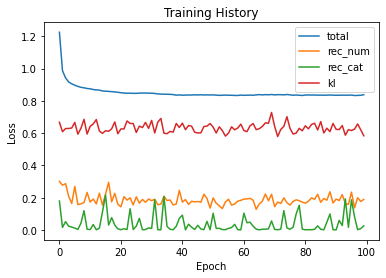

In [16]:
# Plot model loss/training progress
plt.plot(history.history['total_loss'])
plt.plot(history.history['reconstruction_loss_num'])
plt.plot(history.history['reconstruction_loss_cat'])
plt.plot(history.history['kl_loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec_num","rec_cat","kl"], loc="upper right")
plt.show()

## Testing

In [17]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = encoder.predict(test_data)

# Determine the average values for the mean/logvariance of the latent variables
for i in range(0, LATENT_DIM):
    avg_mean = np.mean(z_mean[:,i])
    avg_logvar = np.mean(z_logvar[:,i])
    print(f"Latent Variable: {i}")
    print(f"Mean: {avg_mean}")
    print(f"Variance: {np.exp(avg_logvar)}\n")

Latent Variable: 0
Mean: 0.07164976000785828
Variance: 0.14533233642578125

Latent Variable: 1
Mean: -0.037371378391981125
Variance: 0.37923139333724976

Latent Variable: 2
Mean: 0.01334515679627657
Variance: 0.1584818959236145

Latent Variable: 3
Mean: 0.00858768355101347
Variance: 0.1219080314040184

Latent Variable: 4
Mean: -0.024075990542769432
Variance: 0.2940439283847809



In [18]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_num, loss_cat = get_reconstruction_loss(test_data, results, CAT_IDX, CAT_LENGTHS)
print(f"Numerical Variable Loss: {loss_num}")
print(f"Categorical Variable Loss: {loss_cat}")

Numerical Variable Loss: 0.1708613783121109
Categorical Variable Loss: 0.026371706277132034


In [19]:
# Transform numeric results back to real variable values
results_num = scaler_test.inverse_transform(results[0])
results_df = pd.DataFrame(results_num)

# Transform categorical results back to real variable values
for x in results[1]:
    result = np.argmax(x, axis=1) + 1
    results_df[f"{x}"] = result

# Add back original variables names to the results
results_df.columns = VAR_NAMES

In [20]:
# Transform numeric test data back to real variable values
test_data_num = scaler_test.inverse_transform(test_data[:,:CAT_IDX])
test_data_df = pd.DataFrame(test_data_num)

# Transform categorical test data back to real variable values
current = CAT_IDX
for x in CAT_LENGTHS:
    test_data_cat = test_data[:,current:(current + x)]
    test_data_cat = np.argmax(test_data_cat, axis=1) + 1
    test_data_df[f"{x}"] = test_data_cat
    current += x

# Add back original variables names to the test data
test_data_df.columns = VAR_NAMES

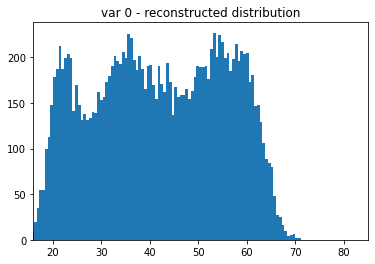

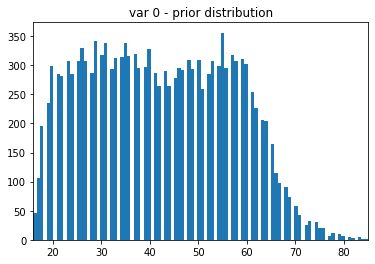

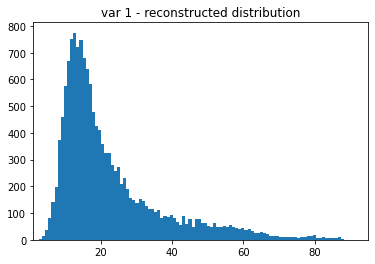

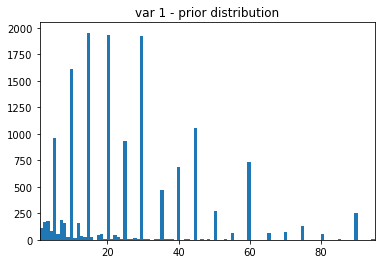

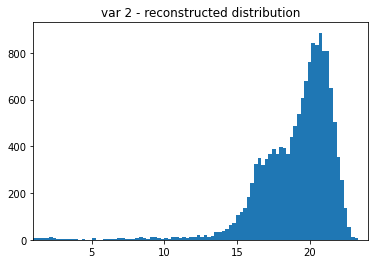

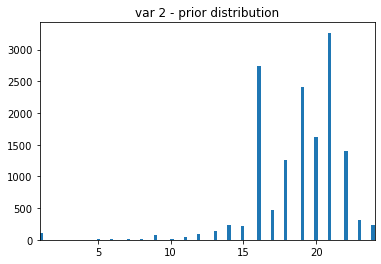

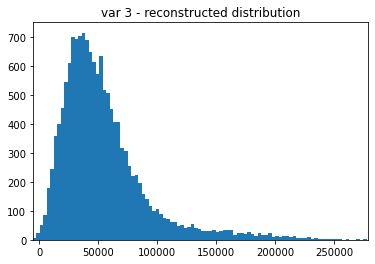

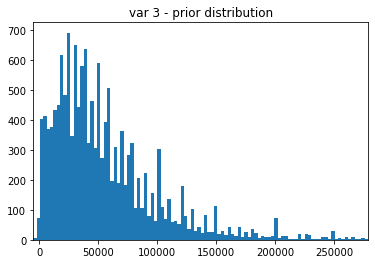

In [21]:
# Show distributions of the resulting numerical variables
for col_idx in range(0, CAT_IDX):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]

    plt.hist(results_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()

    plt.hist(test_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()

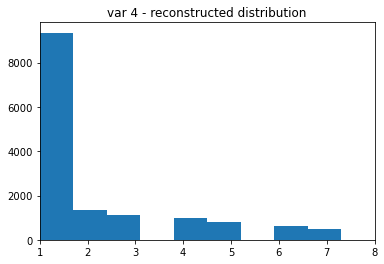

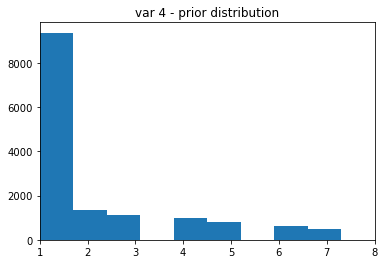

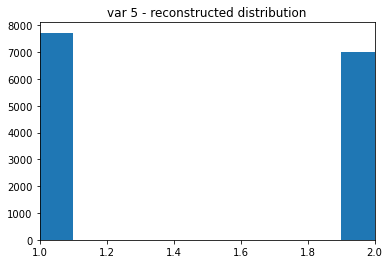

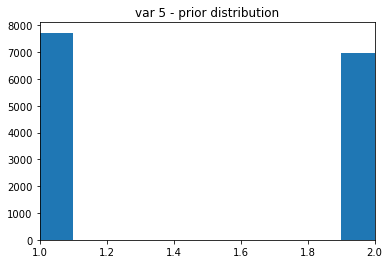

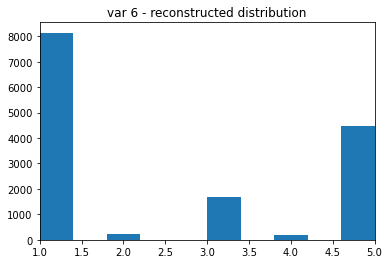

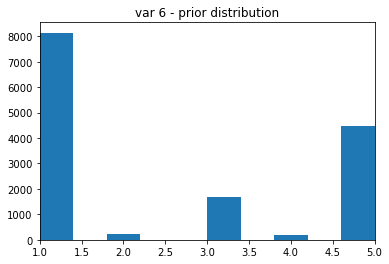

In [22]:
# Show distributions of the resulting numerical variables
for col_idx in range(CAT_IDX, VAR_DIM):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]
    
    plt.hist(results_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()
    
    plt.hist(test_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()